# **Lab 6**

# **Phát hiện bất thường mạng của LSTM Autoencoder**
Trong bài thực hành này, ta sẽ tạo và đào tạo trong LSTM Autoencoder để phát hiện điểm bất thường trên tập dữ liệu  KDD99 về lưu lượng mạng.


**Nhóm 7**

|STT|	Họ và tên|	MSSV	|Email|
|-|--|--|--|
|1|	Trần Hoàng Khang	|19521671|	19521671@gm.uit.edu.vn|
|2|	Nguyễn Tú Ngọc	|20521665	|20521665@gm.uit.edu.vn|




Cấu trúc thư mục:

<center>
  <img src="https://i.imgur.com/DrX1O64.png" alt="folder-structure">
<center>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# **1. Đọc tập dữ liệu KDD99**

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

In [3]:
from tensorflow.keras.utils import get_file
try:
    path = get_file('kddcup.data_10_percent.gz', origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')
except:
    print('Error downloading')
    raise

print(path) 

2144903/2144903 [==============================] - 1s 0us/step
/root/.keras/datasets/kddcup.data_10_percent.gz


In [ ]:
df = pd.read_csv(path, header=None)
print("Read {} rows.".format(len(df)))

Read 494021 rows.


In [ ]:
# CSV không có header, thêm các header name này vào 
df.columns = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot',
              'num_failed_logins','logged_in','num_compromised','root_shell', 'su_attempted','num_root','num_file_creations','num_shells',
              'num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate',
              'rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count',
              'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
              'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome']
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


# **2. Xử lý dữ liệu**

In [ ]:
# loại bỏ NA
df.dropna(inplace=True,axis=1) 
df.shape

(494021, 42)

In [ ]:
df.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

In [ ]:
df.groupby('outcome')['outcome'].count()

outcome
back.                 2203
buffer_overflow.        30
ftp_write.               8
guess_passwd.           53
imap.                   12
ipsweep.              1247
land.                   21
loadmodule.              9
multihop.                7
neptune.            107201
nmap.                  231
normal.              97278
perl.                    3
phf.                     4
pod.                   264
portsweep.            1040
rootkit.                10
satan.                1589
smurf.              280790
spy.                     2
teardrop.              979
warezclient.          1020
warezmaster.            20
Name: outcome, dtype: int64

# **3. Encode dữ liệu số và chữ**

In [ ]:
# Encode cột số
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
# Encode cột chữ ([1,0,0],[0,1,0],[0,0,1] cho red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

In [ ]:
#encoding feature vector
text_col =['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', ]

for i in df.columns:
  if i not in text_col:
    if i != 'outcome':
      encode_numeric_zscore(df, i)

for x in text_col:
  encode_text_dummy(df, x)

In [ ]:
df.dropna(inplace=True,axis=1)
df[0:5]

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag-S3,flag-SF,flag-SH,land-0,land-1,logged_in-0,logged_in-1,is_host_login-0,is_guest_login-0,is_guest_login-1
0,-0.067792,-0.002879,0.138664,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0
1,-0.067792,-0.002820,-0.011578,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0
2,-0.067792,-0.002824,0.014179,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0
3,-0.067792,-0.002840,0.014179,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0
4,-0.067792,-0.002842,0.035214,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0


In [ ]:
df['protocol_type-tcp'].unique()

array([1, 0], dtype=uint8)

In [ ]:
normal_mask = df['outcome']=='normal.'
attack_mask = df['outcome']!='normal.'

df.drop('outcome',axis=1,inplace=True)

df_normal = df[normal_mask]
df_attack = df[attack_mask]

print(f"Normal count: {len(df_normal)}")
print(f"Attack count: {len(df_attack)}")

Normal count: 97278
Attack count: 396743


In [ ]:
# feature vector
x_normal = df_normal.values
x_attack = df_attack.values

In [ ]:
from sklearn.model_selection import train_test_split

x_normal_train, x_normal_test = train_test_split(x_normal, test_size=0.3, random_state=12)

print(f"Normal train count: {len(x_normal_train)}")
print(f"Normal test count: {len(x_normal_test)}")

Normal train count: 68094
Normal test count: 29184


In [ ]:
x_normal_train.shape, x_normal_test.shape

((68094, 120), (29184, 120))

In [ ]:
#Chia tỷ lệ tập dữ liệu
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

x_normal_train = sc.fit_transform(x_normal_train)
x_normal_test = sc.fit_transform(x_normal_test)
x_normal = sc.fit_transform(x_normal)
x_attack = sc.fit_transform(x_attack)

Tập dữ liệu KDD99 không bao gồm timestamps trong thuộc tính. Cho nên ta sẽ xem điểm dữ liệu xảy ra ở timestamps ngay sau điểm dữ liệu trước đó.

In [ ]:
x_normal_train = pd.DataFrame(x_normal_train)
x_normal_test = pd.DataFrame(x_normal_test)
x_attack = pd.DataFrame(x_attack)
x_normal = pd.DataFrame(x_normal)

In [69]:
#Hàm convert time domain dữ liệu
def create_dataset(X, time_steps):
    Xs = []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
    return np.array(Xs)

In [70]:
# reshape [samples, time_steps, n_features]

TIME_STEPS = 1
Xnormal_train = create_dataset(x_normal_train, TIME_STEPS)
print(Xnormal_train.shape)

(103250, 1, 66)


In [71]:
Xnormal_test = create_dataset(x_normal_test, TIME_STEPS)
print(Xnormal_test.shape)

(44250, 1, 66)


In [72]:
Xattack = create_dataset(x_attack, TIME_STEPS)
print(Xattack.shape)

(52497, 1, 66)


In [73]:
Xnormal = create_dataset(x_normal,TIME_STEPS)
print(Xattack.shape)

(52497, 1, 66)


# **4. Kiến trúc mô hình LSTM Autoencoder**

In [74]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units=64, input_shape=(Xnormal_train.shape[1], Xnormal_train.shape[2])))
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.RepeatVector(n=Xnormal_train.shape[1]))
model.add(keras.layers.LSTM(units=32, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=Xnormal_train.shape[2])))

model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                33536     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 1, 64)            0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 1, 32)             12416     
                                                                 
 dropout_1 (Dropout)         (None, 1, 32)             0         
                                                                 
 time_distributed (TimeDistr  (None, 1, 66)            2178      
 ibuted)                                                

# **5. Huấn luyện mô hình**

In [75]:
history = model.fit(
    Xnormal_train, Xnormal_train,
    epochs=15,
    batch_size=128,
    validation_split=0.2, 
    shuffle = False
)

Epoch 1/15
646/646 [==============================] - 11s 10ms/step - loss: 0.2149 - accuracy: 0.2465 - val_loss: 0.1335 - val_accuracy: 0.3518
Epoch 2/15
646/646 [==============================] - 5s 8ms/step - loss: 0.1536 - accuracy: 0.4414 - val_loss: 0.1115 - val_accuracy: 0.5270
Epoch 3/15
646/646 [==============================] - 5s 8ms/step - loss: 0.1398 - accuracy: 0.5031 - val_loss: 0.1046 - val_accuracy: 0.5716
Epoch 4/15
646/646 [==============================] - 5s 8ms/step - loss: 0.1342 - accuracy: 0.5078 - val_loss: 0.0991 - val_accuracy: 0.5708
Epoch 5/15
646/646 [==============================] - 7s 11ms/step - loss: 0.1307 - accuracy: 0.5051 - val_loss: 0.0961 - val_accuracy: 0.5694
Epoch 6/15
646/646 [==============================] - 7s 11ms/step - loss: 0.1280 - accuracy: 0.5006 - val_loss: 0.0948 - val_accuracy: 0.5642
Epoch 7/15
646/646 [==============================] - 5s 8ms/step - loss: 0.1257 - accuracy: 0.5078 - val_loss: 0.0927 - val_accuracy: 0.5750
Ep

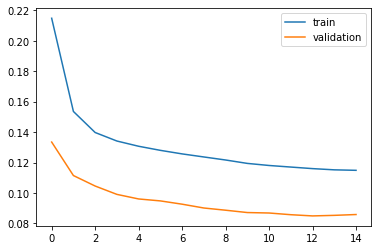

In [76]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend();

# **6. Đánh giá mô hình**

In [ ]:
X_train_pred = model.predict(Xnormal_train)

train_mae_loss = np.mean(np.abs(X_train_pred - Xnormal_train), axis=1)
train_mae_loss.shape

2128/2128 [==============================] - 6s 2ms/step


(68093, 120)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


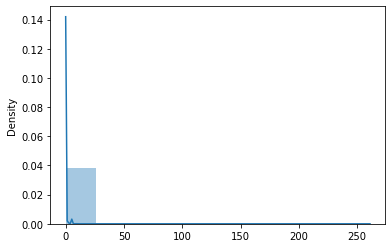

In [ ]:
sns.distplot(train_mae_loss, bins=10, kde=True);

In [ ]:
X_normal_pred = model.predict(Xnormal)

normal_mae_loss = np.mean(np.abs(X_normal_pred - Xnormal), axis=1)
normal_mae_loss.shape

3040/3040 [==============================] - 7s 2ms/step


(97277, 120)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


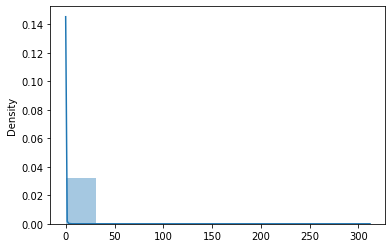

In [ ]:
sns.distplot(normal_mae_loss, bins=10, kde=True);

In [ ]:
score1 = model.evaluate(Xnormal_train, Xnormal_train)
print("\n Sample Loss(MAE) & Accuracy Scores (Train):", score1[0], score1[1], "\n") 

score2 = model.evaluate(Xnormal_test, Xnormal_test)
print("\nOut of Sample Loss(MAE) & Accuracy Scores (Test):", score2[0], score2[1], "\n") 

score3 = model.evaluate(Xattack, Xattack)
print("\nAttack Underway Loss(MAE) & Accuracy Scores (Anomaly):", score3[0], score3[1], "\n") 

2128/2128 [==============================] - 5s 2ms/step - loss: 0.0388 - accuracy: 0.5853

 Sample Loss(MAE) & Accuracy Scores (Train): 0.038828376680612564 0.5852730870246887 

912/912 [==============================] - 2s 3ms/step - loss: 0.0409 - accuracy: 0.5916

Out of Sample Loss(MAE) & Accuracy Scores (Test): 0.04091939702630043 0.5915772914886475 

12399/12399 [==============================] - 32s 3ms/step - loss: 0.1669 - accuracy: 0.7115

Attack Underway Loss(MAE) & Accuracy Scores (Anomaly): 0.1668919175863266 0.7114724516868591 



Kết luận: Độ chính xác của mô hình dự đoán trên tập normal train và set đạt 0,57. Trong khi đó độ chính xác của mô hình khi được huấn luyện trên cả 2 tập normal và attack đạt 0,66.
Sai số - Mean Absolute Error (mae). Dữ liệu normal ở train và test có mae khoảng 0,04 và dữ liệu attack là 0,16

# **7. Bài tập**
**Sinh viên chạy lại tập dữ liệu [CIC IDS 2018](https://www.unb.ca/cic/datasets/ids-2018.html) trên mô hình bài lab này.**



Để bài này hiệu suất được cao hơn bình thường. Mình đã sử dụng (theo GVHD đề xuất):
- Thay đổi hàm [StandarScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) thành [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)
- Thay đổi một số tham số của model
- Thay đổi **Loss function** (Tham khảo [các hàm loss](https://keras.io/api/losses/))

(Cho phần tìm hiểu thêm) 
Công thức scale theo tiêu chuẩn (standard) **StandardScaler**:

```
z = (x - u) / s
```

`x` là sample đang xét, `u` là giá trị **mean**, `s` là [độ lệch chuẩn](https://vietnambiz.vn/do-lech-chuan-standard-deviation-la-gi-cong-thuc-tinh-do-lech-chuan-2019110216112891.htm) ("Read carefully !" - Đây là khái niệm và công thức cơ bản)

Công thức **MinMaxScaler**:

```
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min
```

`X_std` là giá trị độ lệch của giá trị đang xét so với min trên toàn bộ vùng giá trị cho phép trong tập dữ liệu từ (min->max)

`min`, `max` là `feature_range`, giá trị này do chúng ta chỉ định

## a. Lấy dữ liệu từ CIC IDS 2018


### To download this dataset <trích từ link trên>

- Install the AWS CLI, available on Mac, Windows and Linux
- Run: `aws s3 sync --no-sign-request --region <your-region> "s3://cse-cic-ids2018/" dest-dir`(Where **your-region** is your region from the [AWS regions list](https://docs.aws.amazon.com/AWSEC2/latest/UserGuide/using-regions-availability-zones.html#concepts-regions) and **dest-dir** is the name of the desired destination folder in your machine)
- Download AWS CLI: https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html#cliv2-linux-install

In [5]:
!cat /etc/os-release

NAME="Ubuntu"
VERSION="18.04.6 LTS (Bionic Beaver)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 18.04.6 LTS"
VERSION_ID="18.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=bionic
UBUNTU_CODENAME=bionic


In [6]:
%cd /content/drive/MyDrive/Lab/Lab5/Tool/
!curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
!unzip -o awscliv2.zip

Streaming output truncated to the last 5000 lines.
  inflating: aws/dist/awscli/examples/greengrass/create-group-certificate-authority.rst  
  inflating: aws/dist/awscli/examples/greengrass/get-resource-definition-version.rst  
  inflating: aws/dist/awscli/examples/greengrass/create-software-update-job.rst  
  inflating: aws/dist/awscli/examples/greengrass/update-group.rst  
  inflating: aws/dist/awscli/examples/greengrass/get-logger-definition.rst  
  inflating: aws/dist/awscli/examples/greengrass/create-core-definition.rst  
  inflating: aws/dist/awscli/examples/greengrass/list-groups.rst  
  inflating: aws/dist/awscli/examples/greengrass/list-connector-definitions.rst  
  inflating: aws/dist/awscli/examples/greengrass/create-device-definition-version.rst  
  inflating: aws/dist/awscli/examples/greengrass/list-logger-definition-versions.rst  
  inflating: aws/dist/awscli/examples/greengrass/list-function-definition-versions.rst  
  inflating: aws/dist/awscli/examples/greengrass/get-r

In [7]:
! ./aws/install # --update

You can now run: /usr/local/bin/aws --version


In [13]:
! /usr/local/bin/aws --version

aws-cli/2.9.6 Python/3.9.11 Linux/5.10.133+ exe/x86_64.ubuntu.18 prompt/off


In [14]:
!aws s3 ls --no-sign-request --region us-east-2 "s3://cse-cic-ids2018/" # Dùng lệnh "ls" để xem list danh sách file và thư mục

                           PRE Original Network Traffic and Log data/
                           PRE Processed Traffic Data for ML Algorithms/


Chúng ta tập trung vào xử lý file csv đã được xử lý tại thư mục "PRE Processed Traffic Data for ML Algorithms/". (Bỏ qua file RAW)

In [16]:
!aws s3 ls --no-sign-request --region us-east-2 "s3://cse-cic-ids2018/Processed Traffic Data for ML Algorithms/" 

2018-10-11 16:02:25          0 
2018-10-11 16:02:49  352368373 Friday-02-03-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:03:10  333723605 Friday-16-02-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:03:33  382840456 Friday-23-02-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:03:59 4054925350 Thuesday-20-02-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:08:38  107842858 Thursday-01-03-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:08:48  375945899 Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:09:20  382636202 Thursday-22-02-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:09:44  358223333 Wednesday-14-02-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:10:12  328893673 Wednesday-21-02-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:10:33  209249758 Wednesday-28-02-2018_TrafficForML_CICFlowMeter.csv


(Tùy chọn) Download hết dataset (Nếu thích, nhưng sẽ rất nặng)

In [ ]:
!aws s3 sync --no-sign-request --region us-east-2 "s3://cse-cic-ids2018/Processed Traffic Data for ML Algorithms/" ../Dataset

download: s3://cse-cic-ids2018/Processed Traffic Data for ML Algorithms/Friday-02-03-2018_TrafficForML_CICFlowMeter.csv to ../Dataset/Friday-02-03-2018_TrafficForML_CICFlowMeter.csv
download: s3://cse-cic-ids2018/Processed Traffic Data for ML Algorithms/Thursday-01-03-2018_TrafficForML_CICFlowMeter.csv to ../Dataset/Thursday-01-03-2018_TrafficForML_CICFlowMeter.csv
download: s3://cse-cic-ids2018/Processed Traffic Data for ML Algorithms/Friday-23-02-2018_TrafficForML_CICFlowMeter.csv to ../Dataset/Friday-23-02-2018_TrafficForML_CICFlowMeter.csv
download: s3://cse-cic-ids2018/Processed Traffic Data for ML Algorithms/Friday-16-02-2018_TrafficForML_CICFlowMeter.csv to ../Dataset/Friday-16-02-2018_TrafficForML_CICFlowMeter.csv
download: s3://cse-cic-ids2018/Processed Traffic Data for ML Algorithms/Thursday-22-02-2018_TrafficForML_CICFlowMeter.csv to ../Dataset/Thursday-22-02-2018_TrafficForML_CICFlowMeter.csv
download: s3://cse-cic-ids2018/Processed Traffic Data for ML Algorithms/Wednesday-

Download với 1 file để thực hiện bài lab

In [26]:
!aws s3 sync --no-sign-request --region us-east-2 --exclude "*" --include "Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv" "s3://cse-cic-ids2018/Processed Traffic Data for ML Algorithms/"  ../Dataset

download: s3://cse-cic-ids2018/Processed Traffic Data for ML Algorithms/Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv to ../Dataset/Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv


Sử dụng 1 file CSV để phân tích và làm dataset

## b. Đọc và xem thông tin dữ liệu 

In [231]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from tensorflow.keras.utils import get_file

In [232]:
#Load Dataset
df = pd.read_csv("/content/drive/MyDrive/Lab/Lab5/Dataset/Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv", nrows=200000)
df

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,15/02/2018 08:25:18,112641158,3,0,0,0,0,0,...,0,0.0,0.000000,0,0,56320579.0,7.042784e+02,56321077,56320081,Benign
1,22,6,15/02/2018 08:29:05,37366762,14,12,2168,2993,712,0,...,32,1024353.0,649038.754495,1601183,321569,11431221.0,3.644991e+06,15617415,8960247,Benign
2,47514,6,15/02/2018 08:29:42,543,2,0,64,0,64,0,...,32,0.0,0.000000,0,0,0.0,0.000000e+00,0,0,Benign
3,0,0,15/02/2018 08:28:07,112640703,3,0,0,0,0,0,...,0,0.0,0.000000,0,0,56320351.5,3.669884e+02,56320611,56320092,Benign
4,0,0,15/02/2018 08:30:56,112640874,3,0,0,0,0,0,...,0,0.0,0.000000,0,0,56320437.0,7.198347e+02,56320946,56319928,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,53,17,15/02/2018 09:20:30,37205,1,1,32,154,32,32,...,8,0.0,0.000000,0,0,0.0,0.000000e+00,0,0,Benign
199996,53,17,15/02/2018 09:47:06,1136,1,1,31,112,31,31,...,8,0.0,0.000000,0,0,0.0,0.000000e+00,0,0,Benign
199997,53,17,15/02/2018 08:30:08,23786,1,1,34,139,34,34,...,8,0.0,0.000000,0,0,0.0,0.000000e+00,0,0,Benign
199998,53,17,15/02/2018 09:06:27,483,1,1,36,52,36,36,...,8,0.0,0.000000,0,0,0.0,0.000000e+00,0,0,Benign


In [233]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 80 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Dst Port           200000 non-null  int64  
 1   Protocol           200000 non-null  int64  
 2   Timestamp          200000 non-null  object 
 3   Flow Duration      200000 non-null  int64  
 4   Tot Fwd Pkts       200000 non-null  int64  
 5   Tot Bwd Pkts       200000 non-null  int64  
 6   TotLen Fwd Pkts    200000 non-null  int64  
 7   TotLen Bwd Pkts    200000 non-null  int64  
 8   Fwd Pkt Len Max    200000 non-null  int64  
 9   Fwd Pkt Len Min    200000 non-null  int64  
 10  Fwd Pkt Len Mean   200000 non-null  float64
 11  Fwd Pkt Len Std    200000 non-null  float64
 12  Bwd Pkt Len Max    200000 non-null  int64  
 13  Bwd Pkt Len Min    200000 non-null  int64  
 14  Bwd Pkt Len Mean   200000 non-null  float64
 15  Bwd Pkt Len Std    200000 non-null  float64
 16  Fl

In [234]:
df.groupby('Label')['Label'].count()

Label
Benign                   147502
DoS attacks-GoldenEye     41508
DoS attacks-Slowloris     10990
Name: Label, dtype: int64

## c. Xử lý dữ liệu

In [235]:
# Xóa các cột chỉ có 1 giá trị
def distinct_val_of_columns(dataset):
    columns = dataset.columns
    num_val = []
    for column in columns:
        num_val.append(len(dataset[column].unique()))

    col_val_df = pd.DataFrame({'Column': columns, 'Distinct Value': num_val})
    single_val_cols = col_val_df[col_val_df['Distinct Value'] == 1]
    return col_val_df, single_val_cols

In [236]:
# Xóa các cột chỉ có 1 giá trị
col_val_df, single_val_cols = distinct_val_of_columns(df)
df = df.drop(columns= single_val_cols['Column'].values)

# Sắp xếp các record theo thời gian
df = df.sort_values(by=["Timestamp"], ascending=True)

df

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
108690,3389,6,15/02/2018 01:00:00,3686219,10,11,1272,1893,677,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
95790,3389,6,15/02/2018 01:00:01,2465495,8,7,1128,1581,661,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
65323,3389,6,15/02/2018 01:00:01,2502937,8,7,1128,1581,661,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
136781,51773,6,15/02/2018 01:00:01,3,3,0,31,0,31,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
188146,80,6,15/02/2018 01:00:02,79,2,0,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79503,3389,6,15/02/2018 12:59:57,1584311,8,7,1132,1581,661,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
124787,3389,6,15/02/2018 12:59:57,2841919,8,7,1128,1581,661,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
128060,3389,6,15/02/2018 12:59:57,3452438,11,12,2632,1677,677,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
82070,51268,6,15/02/2018 12:59:59,46,1,1,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign


In [237]:
df.drop('Timestamp', axis=1, inplace=True)

In [238]:
# loại bỏ NA
df.dropna(inplace=True,axis=1) 
df.shape

(200000, 68)

## d. Encode dữ liệu số và chữ

In [239]:
# Encode các number values
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
# Encode cho categorical values
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

In [240]:
text_col = []

# Nếu có cột là kiểu dữ liệu object và không xử lý được thì cho các cột này vào `text_col`, may mắn thay, dataset của ta không có cột nào chứa kiểu 'object'
for i in range(df.shape[1]):
  if str(df.dtypes[i]) != "int64" and str(df.dtypes[i]) != "float64":
    if str(df.columns[i]) != "Label":
      text_col.append(df.columns[i])

In [241]:
text_col

[]

In [242]:
#encoding feature vector
for i in df.columns:
  if i not in text_col:
    if i != 'Label':
      encode_numeric_zscore(df, i)

for x in text_col:
  encode_text_dummy(df, x)

In [243]:
df.dropna(inplace=True,axis=1)
df[0:5]

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
108690,-0.146828,-0.557717,-0.382600,0.166139,0.053989,0.005821,-0.020829,1.265176,-0.502715,0.816554,...,0.008693,-0.196099,-0.187984,-0.213869,-0.177945,-0.356449,-0.176218,-0.372576,-0.332321,Benign
95790,-0.146828,-0.557717,-0.417813,0.098496,0.010222,0.003636,-0.023279,1.225087,-0.502715,0.964799,...,0.008693,-0.196099,-0.187984,-0.213869,-0.177945,-0.356449,-0.176218,-0.372576,-0.332321,Benign
65323,-0.146828,-0.557717,-0.416733,0.098496,0.010222,0.003636,-0.023279,1.225087,-0.502715,0.964799,...,0.008693,-0.196099,-0.187984,-0.213869,-0.177945,-0.356449,-0.176218,-0.372576,-0.332321,Benign
136781,2.938113,-0.557717,-0.488933,-0.070610,-0.066370,-0.013007,-0.035690,-0.353405,-0.502715,-0.438873,...,0.008693,-0.196099,-0.187984,-0.213869,-0.177945,-0.356449,-0.176218,-0.372576,-0.332321,Benign
188146,-0.357808,-0.557717,-0.488931,-0.104431,-0.066370,-0.013477,-0.035690,-0.431077,-0.502715,-0.549878,...,0.008693,-0.196099,-0.187984,-0.213869,-0.177945,-0.356449,-0.176218,-0.372576,-0.332321,Benign


In [244]:
normal_mask = df['Label']=='Benign'
attack_mask = df['Label']!='Benign'

df.drop('Label',axis=1,inplace=True)

df_normal = df[normal_mask]
df_attack = df[attack_mask]

print(f"Normal count: {len(df_normal)}")
print(f"Attack count: {len(df_attack)}")

Normal count: 147502
Attack count: 52498


In [245]:
# feature vector
x_normal = df_normal.values
x_attack = df_attack.values

In [246]:
from sklearn.model_selection import train_test_split

x_normal_train, x_normal_test = train_test_split(x_normal, test_size=0.3, random_state=12)

print(f"Normal train count: {len(x_normal_train)}")
print(f"Normal test count: {len(x_normal_test)}")

Normal train count: 103251
Normal test count: 44251


In [247]:
x_normal_train.shape, x_normal_test.shape

((103251, 66), (44251, 66))

In [248]:
#Chia tỷ lệ tập dữ liệu
from sklearn.preprocessing import MinMaxScaler

mmc = MinMaxScaler()

x_normal_train = mmc.fit_transform(x_normal_train)
x_normal_test = mmc.fit_transform(x_normal_test)
x_normal = mmc.fit_transform(x_normal)
x_attack = mmc.fit_transform(x_attack)

In [249]:
x_normal_train = pd.DataFrame(x_normal_train)
x_normal_test = pd.DataFrame(x_normal_test)
x_attack = pd.DataFrame(x_attack)
x_normal = pd.DataFrame(x_normal)

In [250]:
#Convert time step dữ liệu
def create_dataset(X, time_steps):
    Xs = []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
    return np.array(Xs)

In [251]:
# reshape [samples, time_steps, n_features]

TIME_STEPS = 1
Xnormal_train = create_dataset(x_normal_train, TIME_STEPS)
print(Xnormal_train.shape)

(103250, 1, 66)


In [252]:
Xnormal_test = create_dataset(x_normal_test, TIME_STEPS)
print(Xnormal_test.shape)

(44250, 1, 66)


In [253]:
Xattack = create_dataset(x_attack, TIME_STEPS)
print(Xattack.shape)

(52497, 1, 66)


In [254]:
Xnormal = create_dataset(x_normal,TIME_STEPS)
print(Xattack.shape)

(52497, 1, 66)


## e. Mô hình LSTM Autoencder

Có 2 lớp đặc biệt cần làm rõ:

**RepeatVector Layer**: Thực hiện lặp với input **n** lần và đưa vào kết quả đầu ra. Ví dụ:

```
model = Sequential()
model.add(Dense(32, input_dim=32))
# now: model.output_shape == (None, 32)
# note: `None`  là số chiều batch, như bên dưới mình lấy số chiều của input 

model.add(RepeatVector(3))
# now: model.output_shape == (None, 3, 32)
```

**TimeDistributed Layer**:

Nguồn tham khảo: https://phamdinhkhanh.github.io/2019/12/02/DeepLearningLayer.html

Hoạt động gần giống như `Dense`, fully connected với các lớp, ngoài ra còn có tác dụng kết nối tới từng hidden véc tơ ở mỗi bước thời gian `time_step`. Layer này thường xuyên được thấy trong mạng **RNN** và đi cùng với một **LSTM layer**

<center>
  <img src="https://i.imgur.com/ApB2Avu.png" alt="time-distributed">
</center>

In [255]:
# Mô hình kiến trúc LSTM Autoencoder 
# Ở đây mình thay đổi liên tục các tham số để tìm những tham số tốt bằng tay (Manual)
# Nguồn: https://blog.taboola.com/anomaly-detection-using-lstm-autoencoder/

model = keras.Sequential() # Sử dụng model chuỗi, vì đây dạng dữ liệu liên tục được ghi nhận trong một khoảng thời gian
model.add(keras.layers.LSTM(units=64, input_shape=(Xnormal_train.shape[1], Xnormal_train.shape[2]))) # Đây là lớp điển hình của mô hình đang build, có tính chất nhớ từ kết quả training
model.add(keras.layers.Dropout(rate=0.2)) # Ngẫu nhiên loại bỏ một phần unit
# Hay nói cách khác là 1 hidden unit không thể dựa vào 1 unit khác để sửa lỗi lầm của nó, dễ cho chúng ta thấy các hidden unit không đáng tin cậy
# --> Chống overfit

model.add(keras.layers.RepeatVector(n=Xnormal_train.shape[1])) 
model.add(keras.layers.LSTM(units=64, return_sequences=True)) # Chỉnh 'unit' từ 32->64
model.add(keras.layers.Dropout(rate=0.2)) # Chỉnh từ 0.5->0.2
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=Xnormal_train.shape[2])))  

model.compile(loss="mse", optimizer='adam', metrics=['accuracy']) # Ở đây loss function ta dùng 'mse' sẽ cho kết quả cao hơn và hội tụ nhanh hơn
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 64)                33536     
                                                                 
 dropout_28 (Dropout)        (None, 64)                0         
                                                                 
 repeat_vector_14 (RepeatVec  (None, 1, 64)            0         
 tor)                                                            
                                                                 
 lstm_29 (LSTM)              (None, 1, 64)             33024     
                                                                 
 dropout_29 (Dropout)        (None, 1, 64)             0         
                                                                 
 time_distributed_14 (TimeDi  (None, 1, 66)            4290      
 stributed)                                          

## f. Huấn luyện Model

In [256]:
# traning model
history = model.fit(
    Xnormal_train, Xnormal_train,
    epochs=15,
    batch_size=128,
    validation_split=0.2, 
    shuffle = False
)

Epoch 1/15
646/646 [==============================] - 12s 11ms/step - loss: 0.0061 - accuracy: 0.8159 - val_loss: 8.2803e-04 - val_accuracy: 0.8569
Epoch 2/15
646/646 [==============================] - 7s 11ms/step - loss: 0.0020 - accuracy: 0.8571 - val_loss: 5.1416e-04 - val_accuracy: 0.8846
Epoch 3/15
646/646 [==============================] - 6s 10ms/step - loss: 0.0017 - accuracy: 0.8561 - val_loss: 4.1955e-04 - val_accuracy: 0.9011
Epoch 4/15
646/646 [==============================] - 6s 10ms/step - loss: 0.0015 - accuracy: 0.8550 - val_loss: 3.8339e-04 - val_accuracy: 0.8828
Epoch 5/15
646/646 [==============================] - 6s 10ms/step - loss: 0.0014 - accuracy: 0.8541 - val_loss: 3.7377e-04 - val_accuracy: 0.8979
Epoch 6/15
646/646 [==============================] - 6s 10ms/step - loss: 0.0014 - accuracy: 0.8528 - val_loss: 3.5241e-04 - val_accuracy: 0.8962
Epoch 7/15
646/646 [==============================] - 7s 11ms/step - loss: 0.0013 - accuracy: 0.8504 - val_loss: 3.11

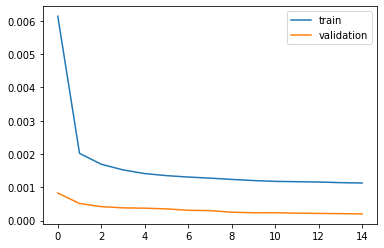

In [257]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend();

## g. Đánh giá model

In [258]:
# model evalutation
X_train_pred = model.predict(Xnormal_train)

train_mse_loss = np.mean(np.abs(X_train_pred - Xnormal_train), axis=1)
train_mse_loss.shape

3227/3227 [==============================] - 8s 2ms/step


(103250, 66)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


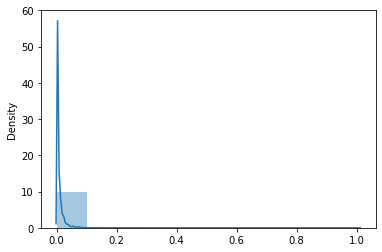

In [259]:
sns.distplot(train_mse_loss, bins=10, kde=True)

In [260]:
X_normal_pred = model.predict(Xnormal)

normal_mse_loss = np.mean(np.abs(X_normal_pred - Xnormal), axis=1)
normal_mse_loss.shape

4610/4610 [==============================] - 10s 2ms/step


(147501, 66)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


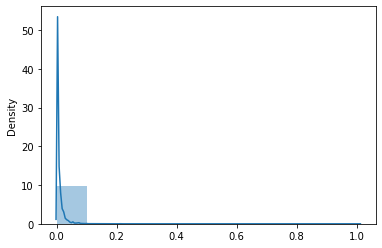

In [261]:
sns.distplot(normal_mse_loss, bins=10, kde=True);

In [262]:
score1 = model.evaluate(Xnormal_train, Xnormal_train)
print("\n Sample Loss(MSE) & Accuracy Scores (Train):", score1[0], score1[1], "\n") 

score2 = model.evaluate(Xnormal_test, Xnormal_test)
print("\nOut of Sample Loss(MSE) & Accuracy Scores (Test):", score2[0], score2[1], "\n") 

score3 = model.evaluate(Xattack, Xattack)
print("\nAttack Underway Loss(MSE) & Accuracy Scores (Anomaly):", score3[0], score3[1], "\n") 

3227/3227 [==============================] - 8s 2ms/step - loss: 2.0407e-04 - accuracy: 0.8999

 Sample Loss(MSE) & Accuracy Scores (Train): 0.00020407278498169035 0.8999031186103821 

1383/1383 [==============================] - 3s 2ms/step - loss: 4.1603e-04 - accuracy: 0.9012

Out of Sample Loss(MSE) & Accuracy Scores (Test): 0.0004160339885856956 0.9012429118156433 

1641/1641 [==============================] - 4s 2ms/step - loss: 0.0614 - accuracy: 0.5514

Attack Underway Loss(MSE) & Accuracy Scores (Anomaly): 0.061444513499736786 0.5514410138130188 

